In [3]:
pip install --quiet --pre torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [4]:
!pip install -Uqq fastbook

In [5]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [6]:
#hide
from fastbook import *

In [7]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [8]:
#hide
Path.BASE_PATH = path

In [9]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [10]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
(path/"images").ls()

(#7393) [Path('images/Russian_Blue_205.jpg'),Path('images/chihuahua_101.jpg'),Path('images/samoyed_9.jpg'),Path('images/basset_hound_101.jpg'),Path('images/Ragdoll_164.jpg'),Path('images/havanese_146.jpg'),Path('images/yorkshire_terrier_150.jpg'),Path('images/saint_bernard_58.jpg'),Path('images/american_pit_bull_terrier_121.jpg'),Path('images/Ragdoll_186.jpg')...]

In [13]:
fname = (path/"images").ls()[0]

In [14]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Russian_Blue']

In [19]:
def ImageBlock1(cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

In [22]:
def CategoryBlock1(vocab=None, sort=True, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))

In [23]:
pets = DataBlock(blocks = (ImageBlock1, CategoryBlock1),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [21]:
CategoryBlock??


In [38]:

def _add_norm(dls, meta, pretrained):
    if not pretrained: return
    stats = meta.get('stats')
    if stats is None: return
    dls.add_tfms([Normalize.from_stats(*stats)],'after_batch')
    
_default_meta    = {'cut':None, 'split':default_split}
@delegates(create_cnn_model)
def cnn_learner1(dls, arch, normalize=True, n_out=None, pretrained=True, config=None,
                # learner args
                loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                # other model args
                **kwargs):
    "Build a convnet style learner from `dls` and `arch`"

    if config:
        warnings.warn('config param is deprecated. Pass your args directly to cnn_learner.')
        kwargs = {**config, **kwargs}

    meta = model_meta.get(arch, _default_meta)
    if normalize: _add_norm(dls, meta, pretrained)

    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = create_cnn_model(arch, n_out, pretrained=pretrained, **kwargs)

    splitter=ifnone(splitter, meta['split'])
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn

In [39]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)


In [33]:
_add_norm??

Object `_add_norm` not found.


In [37]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.576869,0.342346,0.108931,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.518407,0.313694,0.102842,01:11
1,0.328113,0.244460,0.071042,01:11


In [25]:
cnn_learner??

In [ ]:
#hide_input
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this

dls1 = dblock1.dataloaders([('grizzly.jpg')]*100, bs=8)
#dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

FileNotFoundError: ignored

In [41]:
x,y = dls.one_batch()

In [42]:
y

TensorCategory([14, 24,  3, 24, 11,  7, 34,  1, 33, 23, 10, 25, 24, 17,  9, 17,  3,  3, 10, 16, 13, 25, 15, 31, 10,  2, 27,  9, 33,  9,  7, 27,  2, 34, 36, 14,  0, 13, 13,  3, 17, 15, 27, 11,  9, 13, 12, 14,
        12, 27, 34,  3, 28, 22, 19, 34,  1, 15, 10, 27, 22, 10, 13, 24], device='cuda:0')

In [43]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.4941e-17, 1.3276e-20, 1.8128e-06, 9.5892e-13, 8.0501e-19, 1.6866e-02, 1.0029e-12, 1.0338e-16, 3.1222e-02, 1.2794e-17, 1.1762e-20, 5.2204e-12, 3.7508e-15, 3.4796e-21, 5.8995e-01, 1.4945e-05,
        1.0335e-07, 2.1188e-22, 5.7654e-15, 5.3125e-17, 1.7588e-06, 3.7891e-15, 3.6074e-01, 1.3177e-26, 4.9748e-05, 2.7139e-08, 1.6310e-24, 3.3294e-22, 1.3251e-25, 1.0188e-06, 2.3015e-06, 6.0448e-17,
        8.4894e-22, 1.8053e-07, 1.1453e-03, 1.7522e-19, 4.6250e-34])

In [44]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


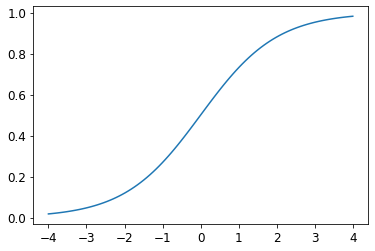

In [45]:
plot_function(torch.sigmoid, min=-4,max=4)

In [46]:
#hide
torch.random.manual_seed(42);

In [47]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [48]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [49]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [50]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [51]:
targ = tensor([0,1,0,1,1,0])

In [52]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [53]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [54]:
#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [55]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [56]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

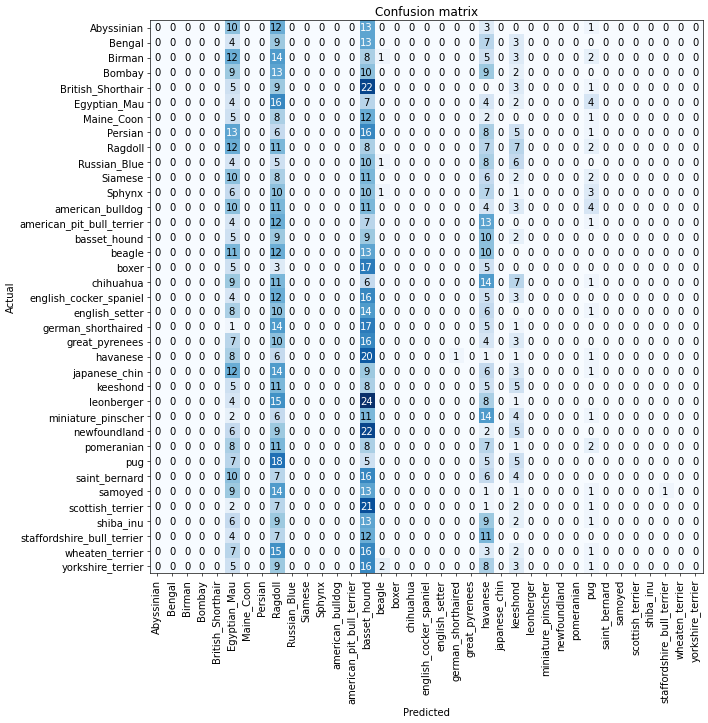

In [57]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [58]:
interp.most_confused(min_val=5)

[('leonberger', 'basset_hound', 24),
 ('British_Shorthair', 'basset_hound', 22),
 ('newfoundland', 'basset_hound', 22),
 ('scottish_terrier', 'basset_hound', 21),
 ('havanese', 'basset_hound', 20),
 ('pug', 'Ragdoll', 18),
 ('boxer', 'basset_hound', 17),
 ('german_shorthaired', 'basset_hound', 17),
 ('Egyptian_Mau', 'Ragdoll', 16),
 ('Persian', 'basset_hound', 16),
 ('english_cocker_spaniel', 'basset_hound', 16),
 ('great_pyrenees', 'basset_hound', 16),
 ('saint_bernard', 'basset_hound', 16),
 ('wheaten_terrier', 'basset_hound', 16),
 ('yorkshire_terrier', 'basset_hound', 16),
 ('leonberger', 'Ragdoll', 15),
 ('wheaten_terrier', 'Ragdoll', 15),
 ('Birman', 'Ragdoll', 14),
 ('chihuahua', 'havanese', 14),
 ('english_setter', 'basset_hound', 14),
 ('german_shorthaired', 'Ragdoll', 14),
 ('japanese_chin', 'Ragdoll', 14),
 ('miniature_pinscher', 'havanese', 14),
 ('samoyed', 'Ragdoll', 14),
 ('Abyssinian', 'basset_hound', 13),
 ('Bengal', 'basset_hound', 13),
 ('Bombay', 'Ragdoll', 13),
 ('

In [59]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.677321,3.846391,0.467524,01:07


epoch,train_loss,valid_loss,error_rate,time
0,3.408768,1.605303,0.479702,01:11


In [64]:
@patch
def lr_find1(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return SuggestedLRs(lr_min/10.,lr_steep)

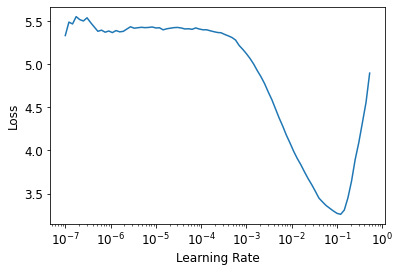

In [65]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find1()

In [66]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 4.37e-03


In [67]:
learn = cnn_learner1(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.322608,0.298131,0.108254,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.558283,0.375539,0.112314,01:11
1,0.358528,0.248015,0.076455,01:11


In [63]:
lr_find??

Object `lr_find` not found.


# New Section